
# TL;DR

1. Target is mostly a mixture of two normal distributions
    1. Most of the targets are constant.
    1. Could be helpful to solve classification first
    2. To extract exact distribution, we can use Gaussian Mixture clustering
2. Targets are stable in time in counts, meaans and stds.
3. No Outliers -> The metrics are MSE, MAE, WAPE
4. __The data is too sinthetic -> The solution can be synthetic (non-productionalizable) too__ 
5. TODO
   1. Get Holdout OOT Dataset
   2. Develop baseline
      1. Log metrics
      2. Develop Universal testing pipeline
   3. Develop CLF Model
      3. CLF Metrics - same as for REGR
   4. Develop REGR Model as residuals of CLF  

# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = Path('..', 'data')
data_path.exists()

True

In [3]:
PERCENTILES = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

# Data

In [4]:
url = 'https://docs.google.com/spreadsheets/d/1pEDydV8JV2H2rTZmQD9DVhRf7QTX0KmuHr-NX2XPj98/edit?usp=sharing'
sheet_id = url.split('/')[-2]
dwn_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

df = pd.read_csv(dwn_url, on_bad_lines='warn')
df.info(verbose=True, show_counts=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 10000 non-null  object 
 1   location                10000 non-null  object 
 2   gender                  10000 non-null  object 
 3   acquisition_date        10000 non-null  object 
 4   acquisition_channel     10000 non-null  object 
 5   eCPM                    10000 non-null  float64
 6   total_time_spent        10000 non-null  float64
 7   avg_session_time        10000 non-null  float64
 8   num_games_played        10000 non-null  int64  
 9   favorite_game_genre     10000 non-null  object 
 10  total_rewards           10000 non-null  int64  
 11  total_coins             10000 non-null  int64  
 12  cashouts                10000 non-null  float64
 13  logins_past_7_days      10000 non-null  int64  
 14  total_logins            10000 non-null 

,user_id,location,gender,acquisition_date,acquisition_channel,eCPM,total_time_spent,avg_session_time,num_games_played,favorite_game_genre,...,cashouts,logins_past_7_days,total_logins,avg_daily_logins,notifications_received,ads_watched,ltv_day1,ltv_day7,ltv_day30,ltv_day180
0,u000000,Australia,Female,2024-04-08,In-App Ads,1.341458,128.150370,30.236412,65,Sports,...,173.913497,12,668,7.571228,54,131,2.500000,6.7,15.000000,40.0
1,u000001,France,Other,2023-09-28,In-App Ads,1.203097,34.064418,9.079346,97,Puzzle,...,85.865826,8,794,7.062567,22,336,2.500000,6.7,15.000000,40.0
2,u000002,Brazil,Male,2024-04-24,Referral,0.395693,96.559973,31.423285,97,Puzzle,...,195.228450,13,520,4.848931,54,182,2.311357,6.7,14.578598,25.0
3,u000003,Australia,Female,2023-10-17,In-App Ads,0.560207,691.653864,19.581271,19,Puzzle,...,154.958251,14,720,2.716627,7,404,2.500000,6.7,15.000000,40.0
4,u000004,Germany,Female,2023-12-15,Email,3.318075,411.067262,19.680246,7,Action,...,81.093215,14,175,3.753371,13,66,2.194381,6.7,15.000000,25.0


In [5]:
df.acquisition_date = pd.to_datetime(df.acquisition_date)

# Target Distribution

In [6]:
targets = df.columns[df.columns.str.startswith('ltv_')]
targets

Index(['ltv_day1', 'ltv_day7', 'ltv_day30', 'ltv_day180'], dtype='object')

In [7]:
df[targets].describe(percentiles=PERCENTILES)

,ltv_day1,ltv_day7,ltv_day30,ltv_day180
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.348555,6.415935,14.427562,34.166371
std,0.319216,0.676244,1.119436,6.463093
min,1.500000,4.500000,12.000000,25.000000
1%,1.500000,4.500000,12.000000,25.000000
5%,1.500000,4.500000,12.000000,25.000000
25%,2.500000,6.700000,15.000000,25.751337
50%,2.500000,6.700000,15.000000,37.826891
75%,2.500000,6.700000,15.000000,40.000000
95%,2.500000,6.700000,15.000000,40.000000


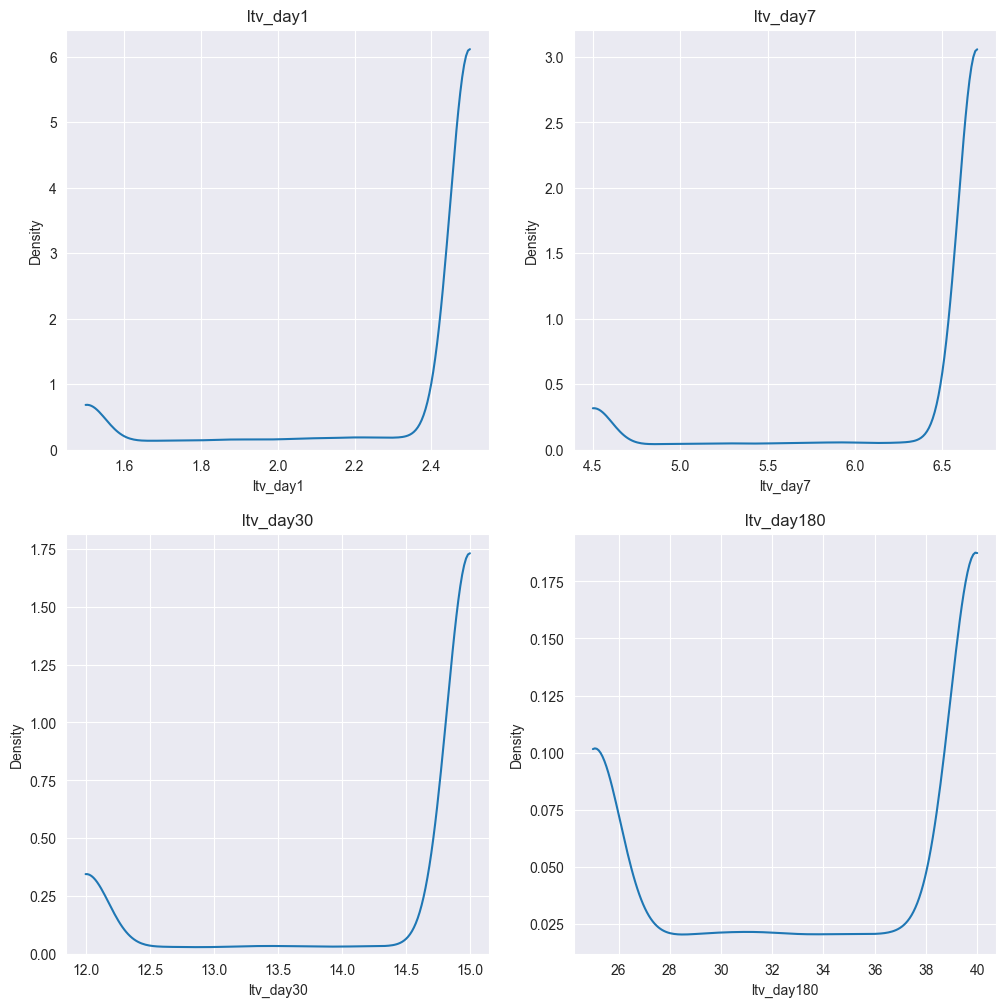

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for target, ax in zip(targets, axes.flat):
    sns.kdeplot(data=df, x=target, ax=ax, cut=0)
    ax.set_title(target)

In [9]:
df[targets].corr()

,ltv_day1,ltv_day7,ltv_day30,ltv_day180
ltv_day1,1.000000,0.968115,0.951337,0.672610
ltv_day7,0.968115,1.000000,0.893139,0.595816
ltv_day30,0.951337,0.893139,1.000000,0.724810
ltv_day180,0.672610,0.595816,0.724810,1.000000


In [10]:
df[targets].nunique()

ltv_day1      1574
ltv_day7      1065
ltv_day30      905
ltv_day180    3091
dtype: int64

In [11]:
pd.concat(
    [
        df[t].value_counts().head(10).reset_index().rename(columns={'index': 'value', t: 'count'})
        for t in targets
    ],
    keys=targets,
    axis=1,
)

ltv_day1        ltv_day7        ltv_day30       ltv_day180      
      count count     count count      count count      count count
0  2.500000  7627  6.700000  8133  15.000000  7625  40.000000  4542
1  1.500000   801  4.500000   804  12.000000  1472  25.000000  2369
2  1.696823     1  6.343224     1  12.077742     1  28.975499     1
3  1.826978     1  4.760788     1  12.923235     1  36.804300     1
4  2.073207     1  6.156705     1  13.675532     1  34.710799     1
5  1.910070     1  5.911400     1  12.998100     1  31.444842     1
6  2.314466     1  4.868173     1  12.418577     1  35.202882     1
7  1.622277     1  4.653843     1  14.710531     1  36.770552     1
8  2.278490     1  5.205466     1  12.624971     1  29.509872     1
9  2.196833     1  5.900716     1  12.059542     1  25.908907     1

In [12]:
df[targets].value_counts().head(10)

ltv_day1  ltv_day7  ltv_day30  ltv_day180
2.5       6.700000  15.0       40.000000     4542
1.5       4.500000  12.0       25.000000      741
2.5       6.700000  15.0       25.000000       47
1.5       4.505075  12.0       25.000000        1
2.5       6.700000  15.0       32.586957        1
                               32.578712        1
                               32.571342        1
                               32.569808        1
                               32.567369        1
                               32.551392        1
Name: count, dtype: int64

<Axes: xlabel='acquisition_date'>

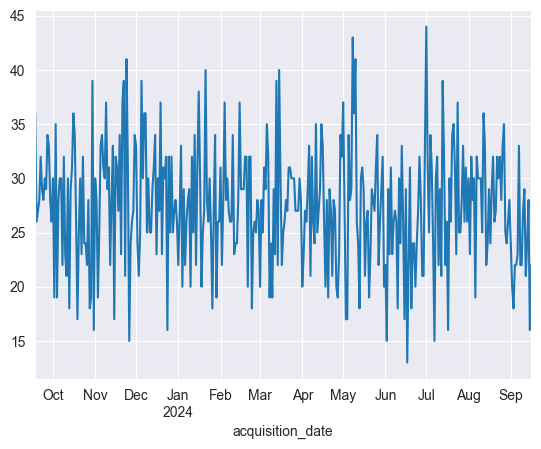

In [13]:
df.acquisition_date.value_counts().sort_index().plot()

<Axes: xlabel='acquisition_date'>

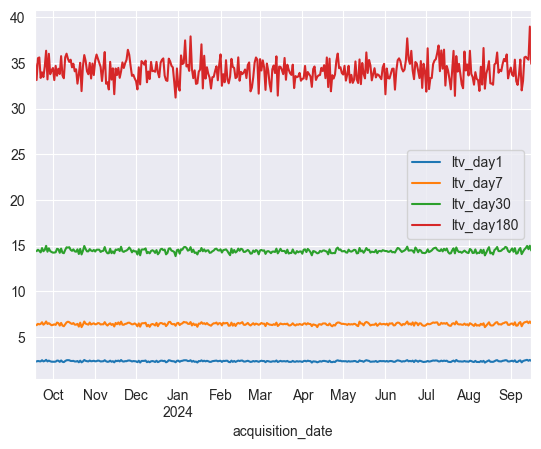

In [14]:
df.groupby('acquisition_date')[targets].mean().plot()

<Axes: xlabel='acquisition_date'>

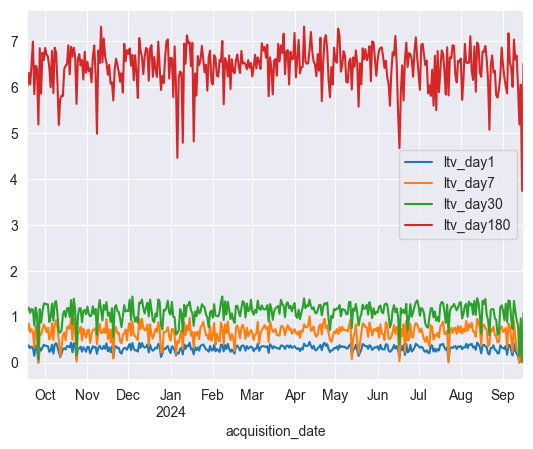

In [15]:
df.groupby('acquisition_date')[targets].std().plot()

# Holdout

<Axes: xlabel='acquisition_date'>

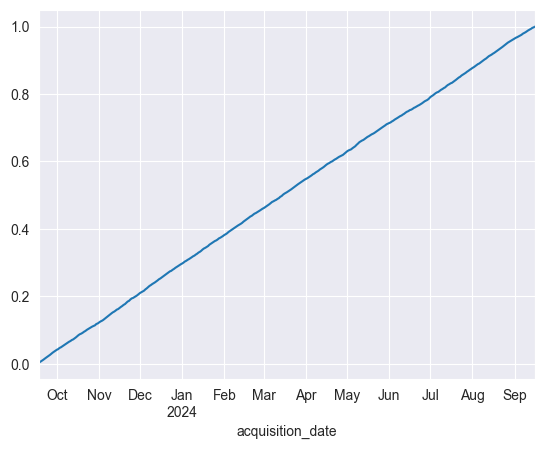

In [16]:
df.acquisition_date.value_counts(normalize=True).sort_index().cumsum().plot()

In [17]:
df.acquisition_date.quantile(0.7)

Timestamp('2024-05-27 00:00:00')

In [18]:
threshold = '2024-05-27'
(df.acquisition_date >= threshold).value_counts(normalize=True)

acquisition_date
False    0.6994
True     0.3006
Name: proportion, dtype: float64

In [19]:
holdout = df[df.acquisition_date >= threshold]
train = df[df.acquisition_date < threshold]
train.shape, holdout.shape

((6994, 22), (3006, 22))

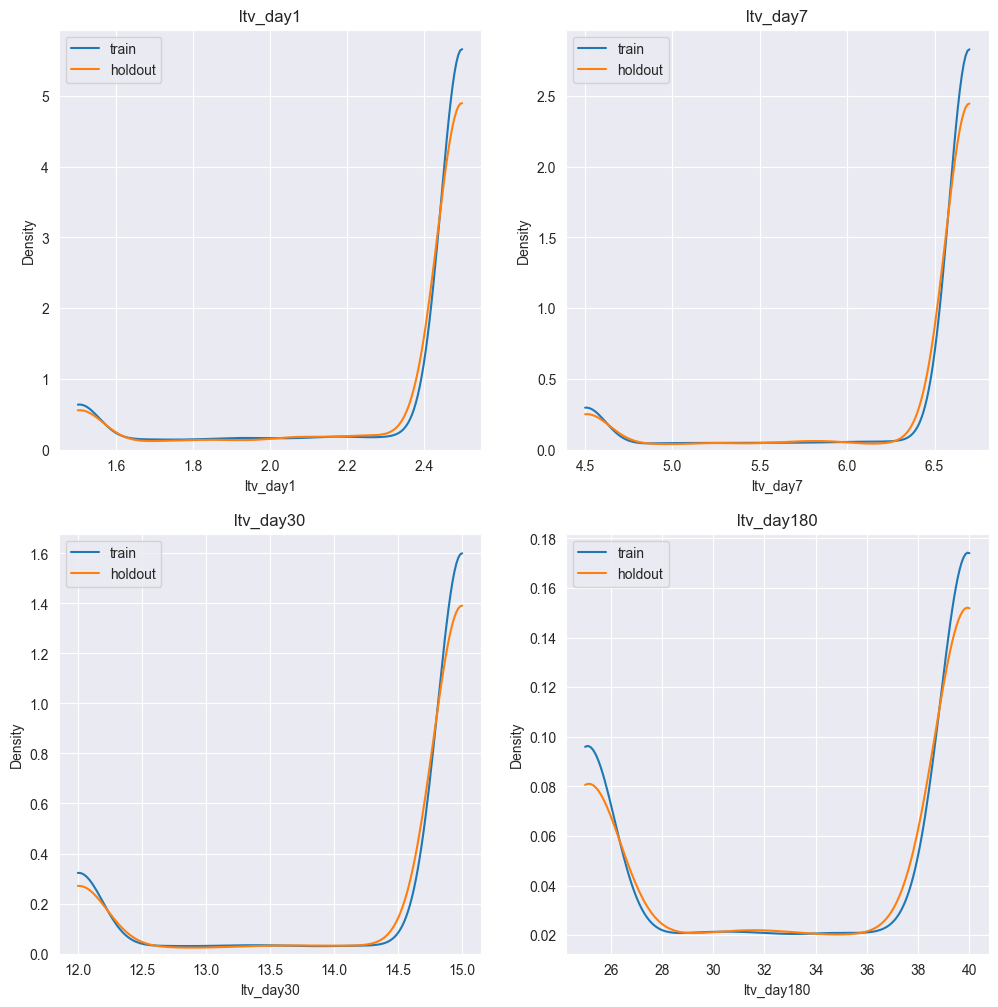

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for target, ax in zip(targets, axes.flat):
    sns.kdeplot(data=train, x=target, ax=ax, cut=0, label='train')
    sns.kdeplot(data=holdout, x=target, ax=ax, cut=0, label='holdout')
    ax.set_title(target)
    ax.legend()

In [21]:
holdout.reset_index(drop=True).to_feather(data_path.joinpath('holdout.feather'))
train.reset_index(drop=True).to_feather(data_path.joinpath('train.feather'))